In [1]:
!pwd

/orfeo/cephfs/home/dssc/adellasiega/XAI_Monuments


In [2]:
import torch
from torchvision import models, transforms
from PIL import Image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import keras

2024-11-21 11:31:06.567873: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 11:31:06.582325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732185066.600006 2013216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732185066.605423 2013216 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 11:31:06.624382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
def load_detector(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 91 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

detector = load_detector(num_classes).to(device)

model_path = "./model/model_monumenai.pth"
detector.load_state_dict(torch.load(model_path, map_location=device))
detector.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),         
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)


image_paths = [
    "./Data/Dataset-IGRB1092_14cls/01.musulman/medina_azahara14.jpg",
    "./Data/Dataset-IGRB1092_14cls/02.gotico/torre_fadrique3.jpg",
    "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg",
    #"./Data/Dataset-IGRB1092_14cls/04.barroco/convento_carmelitas_descalzas_granada6.jpg",
    #"./Data/Dataset-IGRB1092_14cls/04.barroco/20181212_105011.jpg"

]

input_images = [preprocess_image(img_path).to(device) for img_path in image_paths]

with torch.no_grad():
    outputs = detector(input_images)

for idx, output in enumerate(outputs):
    print(f"Risultati per immagine {idx + 1}:")
    print("Bounding boxes:", output["boxes"])
    print("Classi:", output["labels"])
    print("Punteggi:", output["scores"])

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,


Risultati per immagine 1:
Bounding boxes: tensor([[3.4188e+02, 2.2369e+02, 4.7985e+02, 3.6502e+02],
        [2.1267e+02, 2.3651e+02, 3.2892e+02, 3.7378e+02],
        [9.9181e+01, 2.5482e+02, 2.0448e+02, 3.7178e+02],
        [3.2759e+02, 1.2213e+02, 5.0045e+02, 2.3505e+02],
        [1.2908e+01, 6.1953e+00, 5.3295e+02, 1.3161e+02],
        [3.2049e+02, 1.2229e+02, 4.8582e+02, 2.2845e+02],
        [9.0646e+01, 1.6437e+02, 2.1251e+02, 2.6536e+02],
        [2.0476e+02, 1.4461e+02, 3.3024e+02, 2.1876e+02],
        [9.0394e+01, 1.8068e+02, 2.1737e+02, 3.4256e+02],
        [2.0264e+02, 1.4511e+02, 3.2976e+02, 2.3357e+02],
        [1.2354e+02, 0.0000e+00, 5.1290e+02, 9.2572e+01],
        [9.4132e+01, 1.6891e+02, 2.0891e+02, 2.5337e+02],
        [2.0636e+02, 1.4285e+02, 3.2967e+02, 2.6335e+02],
        [3.1928e+02, 1.4198e+02, 5.0566e+02, 3.6828e+02],
        [3.3295e+02, 1.1895e+02, 5.0028e+02, 2.3910e+02],
        [3.5156e+02, 1.0164e+02, 4.8087e+02, 1.3498e+02],
        [9.7342e+01, 4.5244e-0

In [4]:
def extract_features(detector, input_images):
    """
    Estrae feature numeriche dalle immagini originali usando il backbone del detector.
    """
    detector.eval()
    with torch.no_grad():
        # Ottieni i risultati del detector
        outputs = detector(input_images)

        # Lista per salvare le feature estratte
        features_list = []

        # Itera sulle immagini
        for idx, output in enumerate(outputs):
            boxes = output["boxes"]
            labels = output["labels"]
            scores = output["scores"]

            # Usa solo le regioni con punteggi sufficientemente alti
            high_score_indices = scores > 0.5
            filtered_boxes = boxes[high_score_indices]
            filtered_labels = labels[high_score_indices]

            # Calcola una rappresentazione numerica per ogni box
            # Qui potresti aggiungere un estrattore di feature specifico
            # Per esempio, media dei valori pixel, oppure usare il backbone del detector
            features = []
            for box in filtered_boxes:
                cropped_image = input_images[idx][:, int(box[1]):int(box[3]), int(box[0]):int(box[2])]
                # Calcola qualche statistica o passa il crop in un modello
                features.append(cropped_image.mean().item())  # Dummy: usa feature più significative

            features_list.append(features)

        return features_list
# Prepara le feature per il classificatore
features = extract_features(detector, input_images)

# Assumi che ogni immagine produca un array di dimensioni compatibili con il classificatore
# Puoi usare padding o altre tecniche per uniformare la lunghezza
prepared_features = np.zeros((len(features), 17))  # Supponendo che il classificatore si aspetti 17 feature
for i, feat in enumerate(features):
    prepared_features[i, :len(feat)] = feat[:17]  # Trunca o pad per uniformare


In [5]:
# Passa le feature al classificatore
num_archi_features = 17
classificator = keras.Sequential()
classificator.add(keras.layers.Dense(units=11, activation='relu', input_shape=(num_archi_features,)))
classificator.add(keras.layers.Dense(units=4, activation='softmax'))
classificator.load_weights("model/classificator.weights.h5")

/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1732185071.418554 2013216 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
predicted_probabilities = classificator.predict(prepared_features)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
for i, pred_class in enumerate(predicted_classes):
    print(f"Immagine {i + 1}: Stile predetto: {styles_map[pred_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Immagine 1: Stile predetto: Hispanic-muslim
Immagine 2: Stile predetto: Gotic
Immagine 3: Stile predetto: Hispanic-muslim


In [7]:
def predict_style_with_explanations(detector, classificator, image_path, threshold=0.5, styles_map=None):
    # Preprocessa l'immagine
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(next(detector.parameters()).device)

    # Ottieni i risultati del detector
    detector.eval()
    with torch.no_grad():
        outputs = detector(input_image)

    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]
    labels = outputs[0]["labels"]

    # Filtra le bounding box con punteggio sopra il threshold
    high_score_indices = scores > threshold
    filtered_boxes = boxes[high_score_indices]
    filtered_scores = scores[high_score_indices]
    filtered_labels = labels[high_score_indices]

    # Prepara le feature basandoti sui riquadri selezionati
    features = []
    for box in filtered_boxes:
        x_min, y_min, x_max, y_max = box.int().cpu().numpy()
        cropped_image = input_image[0, :, y_min:y_max, x_min:x_max]
        feature = cropped_image.mean().item()  # Dummy: sostituire con feature più significative
        features.append(feature)

    # Pad/Tronca le feature per adattarle al classificatore
    max_features = classificator.input_shape[-1]  # Supponendo input_shape di Keras
    prepared_features = np.zeros((1, max_features))
    prepared_features[0, :len(features)] = features[:max_features]

    # Predici lo stile
    predicted_probabilities = classificator.predict(prepared_features)
    predicted_class = np.argmax(predicted_probabilities, axis=1)[0]
    predicted_style = styles_map[predicted_class] if styles_map else predicted_class

    # SHAP per interpretare
    explainer = shap.KernelExplainer(classificator.predict, prepared_features)
    shap_values = explainer.shap_values(prepared_features, nsamples=30)

    return image, filtered_boxes.cpu().numpy(), shap_values, predicted_style


In [8]:
def visualize_explanations(image, boxes, shap_values, predicted_style, styles_map=None):
    shap_scores = np.array([abs(val) for val in shap_values[0][0]])  # Assumi SHAP per la prima classe
    
    # Gestisci mismatch tra SHAP e riquadri
    if len(shap_scores) < len(boxes):
        print("Avviso: meno valori SHAP rispetto ai riquadri. Riempiendo con zero.")
        shap_scores = np.pad(shap_scores, (0, len(boxes) - len(shap_scores)), constant_values=0)
    
    elif len(shap_scores) > len(boxes):
        print("Avviso: più valori SHAP rispetto ai riquadri. Troncando.")
        shap_scores = shap_scores[:len(boxes)]
        
    # Mostra immagine con riquadri
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Sovrapponi i riquadri
    shap_scores = shap_scores / shap_scores.max()  # Normalizza
    for i, box in enumerate(boxes):
        print(box)
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=5, edgecolor=plt.cm.Reds(0.7), facecolor='none')
        ax.add_patch(rect)
        
    # Predizione
    title = f"Predizione dello stile: {predicted_style}"
    ax.set_title(title, fontsize=16)
    plt.axis("off")
    plt.show()

In [9]:
styles_map = {0: "Hispanic-muslim", 1: "Gotic", 2: "Renaissance", 3: "Baroque"}
image_path = "./Data/Dataset-IGRB1092_14cls/03.renacentista/palacio_carlos_v_granada19.jpg"

image, boxes, shap_values, predicted_style = predict_style_with_explanations(
    detector, classificator, image_path, threshold=0.5, styles_map=styles_map
)
print(shap_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.54it/s]

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


Caricamento checkpoint del detector da: ./tools/checkpoints3/detector_epoch_3.pth
Checkpoint del detector caricato con successo: epoca 3
Caricamento pesi del classificator da: ./tools/checkpoints3/classificator_epoch_3.weights.h5
Checkpoint del classificator caricato con successo da: ./tools/checkpoints3/classificator_epoch_3.weights.h5

=== Bounding Boxes Rilevati: 5 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.52375984 0.33223292 0.07625964 0.06774755]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(1130), np.int32(765), np.int32(1307), np.int32(897))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.15it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 2: (np.int32(543), np.int32(426), np.int32(889), np.int32(650))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 3: (np.int32(117), np.int32(757), np.int32(283), np.int32(871))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 4: (np.int32(530), np.int32(430), np.int32(897), np.int32(687))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 5: (np.int32(1114), np.int32(757), np.int32(1311), np.int32(928))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182


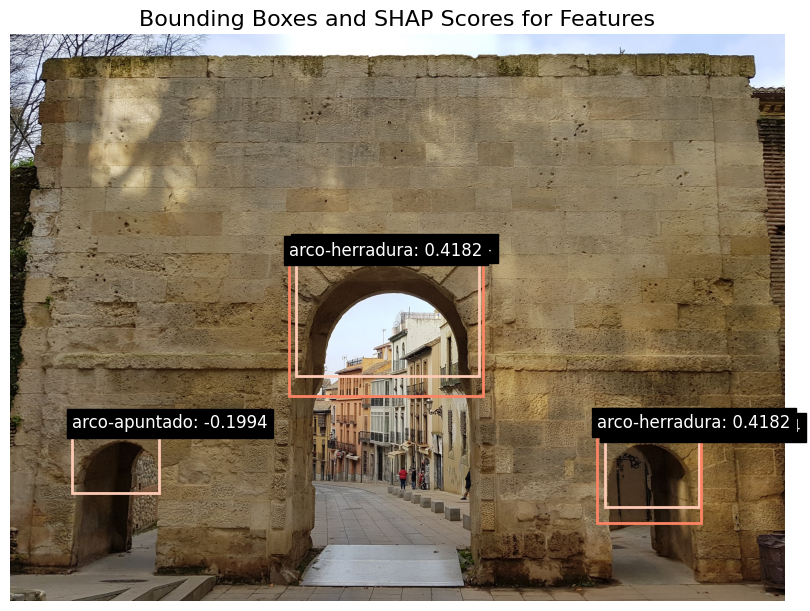

In [10]:
import os
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
import shap
from tensorflow import keras

CHECKPOINT_DIR = "./tools/checkpoints3"

# Feature definite in ELEMENT_DIC
ELEMENT_DIC = {
    'hispanic-muslim': ['arco-herradura', 'arco-lobulado', 'dintel-adovelado'],
    'gothic': ['arco-apuntado', 'arco-conopial', 'arco-trilobulado'],
    'renaissance': ['arco-medio-punto', 'vano-adintelado', 'ojo-de-buey', 'fronton', 'fronton-curvo', 'serliana'],
    'baroque': ['arco-medio-punto', 'vano-adintelado', 'ojo-de-buey', 'fronton-partito', 'columna-salomonica']
}
archi_features = [feature for sublist in ELEMENT_DIC.values() for feature in sublist]

# Funzione per caricare il checkpoint più recente del detector
def load_latest_detector_checkpoint(detector, checkpoint_dir, device):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("detector_epoch")]
    if checkpoints:
        last_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[2].split('.')[0]))
        checkpoint_path = os.path.join(checkpoint_dir, last_checkpoint)
        print(f"Caricamento checkpoint del detector da: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        detector.load_state_dict(checkpoint['model_state_dict'])
        print(f"Checkpoint del detector caricato con successo: epoca {checkpoint['epoch']}")
    else:
        print(f"Nessun checkpoint trovato per il detector nella directory: {checkpoint_dir}")

# Funzione per caricare il checkpoint più recente del classificator
def load_latest_classificator_checkpoint(classificator, checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.startswith("classificator_epoch")]
    if checkpoints:
        last_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[2].split('.')[0]))
        checkpoint_path = os.path.join(checkpoint_dir, last_checkpoint)
        print(f"Caricamento pesi del classificator da: {checkpoint_path}")
        classificator.load_weights(checkpoint_path)
        print(f"Checkpoint del classificator caricato con successo da: {checkpoint_path}")
    else:
        print(f"Nessun checkpoint trovato per il classificator nella directory: {checkpoint_dir}")

def predict_and_explain(detector, classificator, image_path, threshold=0.5, styles_map=None, archi_features=None, device='cpu'):
    """
    Predice lo stile globale e calcola i valori SHAP per le feature rilevate rispetto a quello stile.
    """
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Errore nel caricamento dell'immagine: {str(e)}")
        return None, None, None

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0).to(device)

    # Inference del detector
    detector.eval()
    with torch.no_grad():
        outputs = detector(input_image)

    # Bounding boxes e oggetti rilevati
    boxes = outputs[0]["boxes"]
    scores = outputs[0]["scores"]
    labels = outputs[0]["labels"]

    high_score_indices = scores > threshold
    filtered_boxes = boxes[high_score_indices]
    filtered_labels = labels[high_score_indices]

    print(f"\n=== Bounding Boxes Rilevati: {len(filtered_boxes)} ===")

    # Creazione del feature vector globale
    global_feature_vector = np.zeros((1, len(archi_features)))
    for label in filtered_labels:
        feature_index = label.item() - 1
        global_feature_vector[0, feature_index] = 1

    print(f"Feature vector globale: {global_feature_vector}")

    # Normalizza il feature vector globale
    global_feature_vector = global_feature_vector / np.sum(global_feature_vector)
    print(f"Feature vector globale normalizzato: {global_feature_vector}")

    # Predizione dello stile globale
    global_predicted_probabilities = classificator.predict(global_feature_vector)
    print(f"Probabilità delle classi: {global_predicted_probabilities}")
    global_predicted_class = np.argmax(global_predicted_probabilities, axis=1)[0]
    global_predicted_style = styles_map[global_predicted_class] if styles_map else global_predicted_class
    print(f"Stile globale predetto: {global_predicted_style}")

    # Calcolo baseline per SHAP
    baseline = np.zeros((1, len(archi_features)))
    explainer = shap.KernelExplainer(lambda x: classificator.predict(x)[:, global_predicted_class], baseline)

    shap_values_per_box = []

    for idx, (box, label) in enumerate(zip(filtered_boxes, filtered_labels)):
        x_min, y_min, x_max, y_max = box.int().cpu().numpy()

        # Identifica la feature architettonica
        detected_feature = archi_features[label.item() - 1]
        print(f"\nBounding Box {idx + 1}: {x_min, y_min, x_max, y_max}")
        print(f"  Feature rilevata: {detected_feature}")

        # Prepara il vettore delle feature per la feature rilevata
        feature_vector = np.zeros((1, len(archi_features)))
        feature_vector[0, archi_features.index(detected_feature)] = 1

        try:
            shap_values = explainer.shap_values(feature_vector, nsamples=100)
            print(f"  SHAP values debug: {shap_values}")

            if isinstance(shap_values, list):
                shap_value = shap_values[0][0][archi_features.index(detected_feature)]
            elif isinstance(shap_values, np.ndarray):
                shap_value = shap_values[0, archi_features.index(detected_feature)]
            else:
                raise ValueError("Formato SHAP values non supportato")

            print(f"    SHAP Value per {detected_feature}: {shap_value:.4f}")
            shap_values_per_box.append({detected_feature: shap_value})

        except Exception as e:
            print(f"Errore durante il calcolo dei valori SHAP: {e}")
            shap_values_per_box.append(None)

    return image, filtered_boxes.cpu().numpy(), shap_values_per_box, global_predicted_style

# Funzione di visualizzazione
def visualize_explanations(image, boxes, shap_values_per_box):
    """
    Visualizza i bounding box con i valori SHAP rispetto allo stile globale predetto.
    """
    if image is None or boxes is None:
        print("Impossibile visualizzare le spiegazioni: dati mancanti.")
        return

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box

        if i >= len(shap_values_per_box) or not shap_values_per_box[i]:
            continue

        shap_data = shap_values_per_box[i]
        detected_feature = list(shap_data.keys())[0]
        shap_value = shap_data[detected_feature]

        # Normalizza il valore SHAP per il colore
        normalized_score = abs(shap_value)

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor=plt.cm.Reds(normalized_score),
            facecolor='none'
        )
        ax.add_patch(rect)

        # Aggiungi etichetta con la feature rilevata
        ax.text(x_min, y_min - 10, f"{detected_feature}: {shap_value:.4f}", color="white", fontsize=12, backgroundcolor="black")

    ax.set_title("Bounding Boxes and SHAP Scores for Features", fontsize=16)
    plt.axis("off")
    plt.show()

# Test del sistema
image_path = "./Data/Dataset-IGRB1092_14cls/03.renacentista/20181212_110343.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caricamento dei checkpoint
load_latest_detector_checkpoint(detector, CHECKPOINT_DIR, device)
load_latest_classificator_checkpoint(classificator, CHECKPOINT_DIR)

# Esegui il test
image, boxes, shap_values_per_box, _ = predict_and_explain(
    detector, classificator, image_path, threshold=0.5, styles_map=styles_map, archi_features=archi_features, device=device
)

visualize_explanations(image, boxes, shap_values_per_box)


=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.15004808 0.6577634  0.10066397 0.09152448]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(95), np.int32(13), np.int32(381), np.int32(192))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(390), np.int32(143), np.int32(429), np.int32(180))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 3: (np.int32(61), np.int32(43), np.int32(130), np.int32(97))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.72it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 4: (np.int32(212), np.int32(252), np.int32(284), np.int32(304))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 5: (np.int32(426), np.int32(137), np.int32(467), np.int32(181))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.42it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 6: (np.int32(213), np.int32(253), np.int32(283), np.int32(301))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.25 0.   0.25 0.   0.   0.   0.   0.   0.25 0.25 0.
  0.   0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.29813737 0.36724815 0.18681356 0.14780092]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(141), np.int32(181), np.int32(328), np.int32(225))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 2: (np.int32(170), np.int32(239), np.int32(297), np.int32(326))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 3: (np.int32(183), np.int32(93), np.int32(283), np.int32(127))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.15497911
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1550

Bounding Box 4: (np.int32(137), np.int32(40), np.int32(182), np.int32(89))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033
Gotic



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.25 0.25 0.   0.   0.25 0.25 0.   0.   0.   0.   0.
  0.   0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.20434473 0.5160439  0.15418191 0.12542947]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(429), np.int32(261), np.int32(891), np.int32(539))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.24it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(533), np.int32(530), np.int32(660), np.int32(624))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.24it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 3: (np.int32(681), np.int32(529), np.int32(795), np.int32(598))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.04it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 4: (np.int32(533), np.int32(191), np.int32(768), np.int32(260))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923

Bounding Box 5: (np.int32(1233), np.int32(459), np.int32(1280), np.int32(527))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 6: (np.int32(628), np.int32(43), np.int32(703), np.int32(84))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923
Gotic



=== Bounding Boxes Rilevati: 3 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.12678409 0.483828   0.22221954 0.16716838]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(116), np.int32(347), np.int32(888), np.int32(790))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(0), np.int32(959), np.int32(32), np.int32(1024))
  Feature rilevata: fronton-curvo


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.14423623  0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per fronton-curvo: -0.1442

Bounding Box 3: (np.int32(15), np.int32(55), np.int32(992), np.int32(843))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.6228057  0.23176157 0.07225385 0.07317884]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(517), np.int32(479), np.int32(1136), np.int32(993))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.55it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(1399), np.int32(949), np.int32(1493), np.int32(1224))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.61it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim

=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Probabilità delle classi: [[0.61477387 0.16994716 0.1232984  0.09198055]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(209), np.int32(402), np.int32(823), np.int32(567))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(402), np.int32(36), np.int32(685), np.int32(310))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182
Hispanic-muslim

=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.66782886 0.15330863 0.0982471  0.08061542]]
Stile globale predetto: Hispanic-muslim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(280), np.int32(286), np.int32(627), np.int32(572))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.16it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(95), np.int32(280), np.int32(184), np.int32(349))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 3: (np.int32(676), np.int32(305), np.int32(741), np.int32(363))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 4: (np.int32(244), np.int32(186), np.int32(618), np.int32(250))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.13it/s]

  SHAP values debug: [[0.         0.12108836 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-lobulado: 0.1211
Hispanic-muslim



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.33333333 0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.33333333 0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.3888633  0.32636535 0.1750382  0.10973313]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(102), np.int32(300), np.int32(437), np.int32(629))
  Feature rilevata: dintel-adovelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


  SHAP values debug: [[0.         0.         0.16884449 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per dintel-adovelado: 0.1688

Bounding Box 2: (np.int32(578), np.int32(382), np.int32(982), np.int32(648))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 3: (np.int32(1263), np.int32(251), np.int32(1301), np.int32(283))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 4: (np.int32(1469), np.int32(408), np.int32(1500), np.int32(471))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 5: (np.int32(1099), np.int32(290), np.int32(1424), np.int32(611))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 6: (np.int32(521), np.int32(56), np.int32(1017), np.int32(362))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.66it/s]

  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994
Hispanic-muslim



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.15920493 0.6756728  0.08781649 0.07730565]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(545), np.int32(181), np.int32(818), np.int32(367))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.52it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 2: (np.int32(46), np.int32(170), np.int32(316), np.int32(358))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]

  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.27660972 0.47842503 0.14459468 0.10037056]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(458), np.int32(938), np.int32(998), np.int32(1309))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 2: (np.int32(1490), np.int32(775), np.int32(1534), np.int32(980))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]

  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943
Gotic

=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.         0.33333333
  0.         0.33333333 0.33333333 0.         0.         0.
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.30662984 0.35215476 0.18164991 0.15956551]]
Stile globale predetto: Gotic


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(148), np.int32(155), np.int32(300), np.int32(247))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 2: (np.int32(236), np.int32(290), np.int32(291), np.int32(411))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 3: (np.int32(108), np.int32(104), np.int32(337), np.int32(239))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.24it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 4: (np.int32(111), np.int32(36), np.int32(345), np.int32(179))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.35843945 0.3218617  0.18106283 0.13863602]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Bounding Box 1: (np.int32(280), np.int32(352), np.int32(749), np.int32(934))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(115), np.int32(34), np.int32(957), np.int32(226))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim

=== Bounding Boxes Rilevati: 9 ===
Feature vector globale: [[1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.25 0.   0.   0.   0.25 0.25 0.   0.25 0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.41206878 0.415515   0.0891553  0.083261  ]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(179), np.int32(761), np.int32(280), np.int32(971))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.68it/s]


  SHAP values debug: [[-0.15288931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-herradura: -0.1529

Bounding Box 2: (np.int32(270), np.int32(754), np.int32(350), np.int32(989))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


  SHAP values debug: [[-0.15288931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-herradura: -0.1529

Bounding Box 3: (np.int32(318), np.int32(223), np.int32(717), np.int32(510))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 4: (np.int32(543), np.int32(644), np.int32(688), np.int32(908))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.62it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 5: (np.int32(406), np.int32(169), np.int32(668), np.int32(268))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923

Bounding Box 6: (np.int32(0), np.int32(761), np.int32(92), np.int32(1005))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.29it/s]


  SHAP values debug: [[-0.15288931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-herradura: -0.1529

Bounding Box 7: (np.int32(80), np.int32(762), np.int32(177), np.int32(1007))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


  SHAP values debug: [[-0.15288931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-herradura: -0.1529

Bounding Box 8: (np.int32(151), np.int32(195), np.int32(195), np.int32(271))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 9: (np.int32(120), np.int32(768), np.int32(183), np.int32(886))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]

  SHAP values debug: [[-0.15288931  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-herradura: -0.1529
Gotic



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.33333333 0.
  0.33333333 0.         0.33333333 0.         0.         0.
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.27339846 0.36919397 0.19040132 0.16700625]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(0), np.int32(18), np.int32(893), np.int32(535))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(870), np.int32(25), np.int32(1015), np.int32(110))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 3: (np.int32(245), np.int32(525), np.int32(441), np.int32(642))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 4: (np.int32(482), np.int32(524), np.int32(675), np.int32(629))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]

  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943
Gotic



=== Bounding Boxes Rilevati: 1 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.38304186 0.45838335 0.07419922 0.08437552]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(164), np.int32(218), np.int32(330), np.int32(455))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033
Gotic



=== Bounding Boxes Rilevati: 7 ===
Feature vector globale: [[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.7008684  0.10799977 0.09153744 0.0995944 ]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(278), np.int32(471), np.int32(641), np.int32(718))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.05it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(915), np.int32(547), np.int32(975), np.int32(636))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 3: (np.int32(276), np.int32(124), np.int32(356), np.int32(191))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.96it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 4: (np.int32(355), np.int32(126), np.int32(429), np.int32(184))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 5: (np.int32(433), np.int32(129), np.int32(505), np.int32(187))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 6: (np.int32(0), np.int32(529), np.int32(64), np.int32(617))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 7: (np.int32(752), np.int32(153), np.int32(965), np.int32(199))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.66782886 0.15330863 0.0982471  0.08061542]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(182), np.int32(36), np.int32(622), np.int32(96))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]


  SHAP values debug: [[0.         0.12108836 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-lobulado: 0.1211

Bounding Box 2: (np.int32(221), np.int32(141), np.int32(578), np.int32(462))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182
Hispanic-muslim

=== Bounding Boxes Rilevati: 5 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.33333333 0.         0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.33333333 0.
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.362709   0.33341897 0.16869628 0.13517576]]
Stile globale predetto: Hispanic-muslim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(304), np.int32(180), np.int32(539), np.int32(424))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.29it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(170), np.int32(140), np.int32(238), np.int32(199))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.70it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 3: (np.int32(0), np.int32(206), np.int32(62), np.int32(269))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.51it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 4: (np.int32(576), np.int32(240), np.int32(614), np.int32(292))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 5: (np.int32(579), np.int32(247), np.int32(612), np.int32(292))
  Feature rilevata: fronton-curvo


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]

  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.25960705  0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per fronton-curvo: -0.2596
Hispanic-muslim



=== Bounding Boxes Rilevati: 3 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.35843945 0.3218617  0.18106283 0.13863602]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(244), np.int32(323), np.int32(569), np.int32(643))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(0), np.int32(371), np.int32(105), np.int32(609))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.72it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 3: (np.int32(117), np.int32(113), np.int32(691), np.int32(234))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.95it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.         0.33333333
  0.33333333 0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.40344408 0.25994003 0.18215947 0.15445642]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(887), np.int32(0), np.int32(1012), np.int32(164))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.37it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(591), np.int32(243), np.int32(1355), np.int32(515))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 3: (np.int32(1024), np.int32(0), np.int32(1156), np.int32(164))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 4: (np.int32(774), np.int32(620), np.int32(1210), np.int32(1314))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.48it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 5: (np.int32(0), np.int32(1121), np.int32(472), np.int32(1479))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 6: (np.int32(619), np.int32(256), np.int32(1332), np.int32(483))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.82it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Probabilità delle classi: [[0.17876948 0.29954237 0.29966038 0.22202772]]
Stile globale predetto: Renaissance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(899), np.int32(122), np.int32(2261), np.int32(710))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.75it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.06520727  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.0652

Bounding Box 2: (np.int32(757), np.int32(466), np.int32(2367), np.int32(2167))
  Feature rilevata: fronton


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.22082879 0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per fronton: 0.2208
Renaissance



=== Bounding Boxes Rilevati: 15 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.4596401  0.28071383 0.1171274  0.14251864]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(1298), np.int32(783), np.int32(1562), np.int32(1190))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.16it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(1017), np.int32(1261), np.int32(1230), np.int32(1449))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 3: (np.int32(74), np.int32(1239), np.int32(397), np.int32(1449))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.18it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 4: (np.int32(591), np.int32(1261), np.int32(846), np.int32(1449))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 5: (np.int32(557), np.int32(674), np.int32(865), np.int32(1172))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 6: (np.int32(47), np.int32(573), np.int32(489), np.int32(1148))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 7: (np.int32(957), np.int32(706), np.int32(1305), np.int32(1187))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.56it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 8: (np.int32(515), np.int32(489), np.int32(962), np.int32(697))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.77it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 9: (np.int32(1602), np.int32(1265), np.int32(1766), np.int32(1448))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 10: (np.int32(27), np.int32(388), np.int32(543), np.int32(627))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 11: (np.int32(1539), np.int32(705), np.int32(1784), np.int32(855))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 12: (np.int32(93), np.int32(27), np.int32(562), np.int32(450))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.11it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 13: (np.int32(912), np.int32(555), np.int32(1300), np.int32(746))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 14: (np.int32(1793), np.int32(609), np.int32(1826), np.int32(720))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.94it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 15: (np.int32(596), np.int32(110), np.int32(895), np.int32(405))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.33333333 0.
  0.         0.33333333 0.         0.         0.33333333 0.
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.1568545  0.5010527  0.19647695 0.14561592]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(470), np.int32(508), np.int32(1079), np.int32(825))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923

Bounding Box 2: (np.int32(361), np.int32(719), np.int32(1168), np.int32(1187))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 3: (np.int32(0), np.int32(1395), np.int32(59), np.int32(1492))
  Feature rilevata: fronton-curvo


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.14423623  0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per fronton-curvo: -0.1442

Bounding Box 4: (np.int32(589), np.int32(976), np.int32(939), np.int32(1212))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.76it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.35843945 0.3218617  0.18106283 0.13863602]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(411), np.int32(39), np.int32(1023), np.int32(256))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(430), np.int32(951), np.int32(954), np.int32(1794))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim



=== Bounding Boxes Rilevati: 7 ===
Feature vector globale: [[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.2 0.  0.2 0.2 0.  0.  0.  0.2 0.  0.2 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.2693928  0.339968   0.21922727 0.17141193]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(1030), np.int32(1145), np.int32(1672), np.int32(1292))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.59it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 2: (np.int32(331), np.int32(404), np.int32(689), np.int32(559))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.27it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 3: (np.int32(303), np.int32(1038), np.int32(589), np.int32(1409))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 4: (np.int32(370), np.int32(564), np.int32(633), np.int32(805))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 5: (np.int32(1160), np.int32(1398), np.int32(1600), np.int32(1712))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 6: (np.int32(126), np.int32(1231), np.int32(270), np.int32(1359))
  Feature rilevata: fronton-curvo


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.58it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.14423623  0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per fronton-curvo: -0.1442

Bounding Box 7: (np.int32(1119), np.int32(640), np.int32(1426), np.int32(779))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]

  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049
Gotic



=== Bounding Boxes Rilevati: 5 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.25 0.   0.   0.25 0.   0.   0.25 0.   0.   0.   0.   0.   0.25 0.
  0.   0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.47381756 0.27105677 0.14139245 0.11373323]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(298), np.int32(156), np.int32(1036), np.int32(382))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.28it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(530), np.int32(574), np.int32(848), np.int32(791))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.90it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 3: (np.int32(1070), np.int32(876), np.int32(1236), np.int32(997))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 4: (np.int32(270), np.int32(160), np.int32(1081), np.int32(372))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 5: (np.int32(548), np.int32(570), np.int32(852), np.int32(812))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182
Hispanic-muslim



=== Bounding Boxes Rilevati: 3 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.12678409 0.483828   0.22221954 0.16716838]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(0), np.int32(228), np.int32(31), np.int32(319))
  Feature rilevata: fronton-curvo


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -0.14423623  0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per fronton-curvo: -0.1442

Bounding Box 2: (np.int32(373), np.int32(615), np.int32(604), np.int32(780))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.09it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 3: (np.int32(235), np.int32(516), np.int32(728), np.int32(782))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic

=== Bounding Boxes Rilevati: 7 ===
Feature vector globale: [[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.33333333 0.         0.33333333
  0.33333333 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.3307579  0.450104   0.10692451 0.11221359]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(287), np.int32(656), np.int32(459), np.int32(769))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.25it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 2: (np.int32(163), np.int32(66), np.int32(563), np.int32(241))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.86it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 3: (np.int32(70), np.int32(348), np.int32(194), np.int32(495))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.71it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 4: (np.int32(86), np.int32(6), np.int32(207), np.int32(75))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.50it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 5: (np.int32(585), np.int32(19), np.int32(705), np.int32(136))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 6: (np.int32(553), np.int32(167), np.int32(700), np.int32(273))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 7: (np.int32(108), np.int32(98), np.int32(185), np.int32(190))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033
Gotic



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.33333333 0.         0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.46937323 0.31504768 0.1267483  0.08883085]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(39), np.int32(39), np.int32(429), np.int32(127))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.87it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(105), np.int32(188), np.int32(358), np.int32(373))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 3: (np.int32(96), np.int32(173), np.int32(362), np.int32(393))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 4: (np.int32(79), np.int32(196), np.int32(379), np.int32(508))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.00it/s]

  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994
Hispanic-muslim



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.25 0.   0.   0.25 0.25 0.   0.   0.   0.   0.   0.   0.   0.
  0.25 0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.36781797 0.39736268 0.13445579 0.10036361]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(460), np.int32(830), np.int32(715), np.int32(1054))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(98), np.int32(28), np.int32(212), np.int32(330))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 3: (np.int32(452), np.int32(230), np.int32(492), np.int32(353))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 4: (np.int32(1), np.int32(1061), np.int32(77), np.int32(1211))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.46it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 5: (np.int32(1006), np.int32(2), np.int32(1125), np.int32(88))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 6: (np.int32(222), np.int32(748), np.int32(373), np.int32(822))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.71it/s]

  SHAP values debug: [[ 0.         -0.01161805  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-lobulado: -0.0116
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.6228057  0.23176157 0.07225385 0.07317884]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(208), np.int32(302), np.int32(515), np.int32(539))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.35it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(269), np.int32(487), np.int32(478), np.int32(804))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.12it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim

=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.   0.25 0.25 0.   0.25 0.   0.   0.   0.   0.   0.
  0.25 0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.29335597 0.4824728  0.12231972 0.10185158]]
Stile globale predetto: Gotic


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(98), np.int32(161), np.int32(146), np.int32(240))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.72it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.09427467  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.0943

Bounding Box 2: (np.int32(143), np.int32(411), np.int32(349), np.int32(747))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 3: (np.int32(163), np.int32(197), np.int32(355), np.int32(270))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.49it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923

Bounding Box 4: (np.int32(151), np.int32(226), np.int32(387), np.int32(424))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic



=== Bounding Boxes Rilevati: 10 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.25 0.25 0.25
  0.   0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.34950134 0.21108873 0.25082135 0.18858857]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(229), np.int32(413), np.int32(520), np.int32(797))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(151), np.int32(367), np.int32(224), np.int32(689))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 3: (np.int32(626), np.int32(374), np.int32(710), np.int32(687))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.03it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 4: (np.int32(511), np.int32(375), np.int32(581), np.int32(685))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.99it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 5: (np.int32(231), np.int32(3), np.int32(504), np.int32(87))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.97it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 6: (np.int32(28), np.int32(357), np.int32(114), np.int32(688))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 7: (np.int32(105), np.int32(102), np.int32(202), np.int32(148))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.12203762
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1220

Bounding Box 8: (np.int32(528), np.int32(103), np.int32(625), np.int32(147))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.91it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.12203762
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1220

Bounding Box 9: (np.int32(105), np.int32(149), np.int32(594), np.int32(289))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.51it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 10: (np.int32(234), np.int32(2), np.int32(502), np.int32(87))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.54it/s]

  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.12203762
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1220
Hispanic-muslim



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.49097303 0.18688406 0.18682602 0.13531691]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(1192), np.int32(226), np.int32(1267), np.int32(394))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 2: (np.int32(294), np.int32(467), np.int32(368), np.int32(653))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 3: (np.int32(825), np.int32(531), np.int32(857), np.int32(610))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.19it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 4: (np.int32(21), np.int32(476), np.int32(114), np.int32(669))
  Feature rilevata: ojo-de-buey


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.         -0.15114544  0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per ojo-de-buey: -0.1511

Bounding Box 5: (np.int32(1213), np.int32(955), np.int32(1368), np.int32(1028))
  Feature rilevata: dintel-adovelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.87it/s]


  SHAP values debug: [[0.         0.         0.16884449 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per dintel-adovelado: 0.1688

Bounding Box 6: (np.int32(778), np.int32(961), np.int32(986), np.int32(1028))
  Feature rilevata: dintel-adovelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]

  SHAP values debug: [[0.         0.         0.16884449 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per dintel-adovelado: 0.1688
Hispanic-muslim



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.6228057  0.23176157 0.07225385 0.07317884]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(348), np.int32(470), np.int32(608), np.int32(660))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(413), np.int32(617), np.int32(562), np.int32(830))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.86it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim

=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.25 0.25 0.25 0.   0.25 0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.22111581 0.59116024 0.09746087 0.09026308]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(151), np.int32(215), np.int32(1064), np.int32(812))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675

Bounding Box 2: (np.int32(348), np.int32(802), np.int32(966), np.int32(1476))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 3: (np.int32(381), np.int32(31), np.int32(1045), np.int32(299))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]


  SHAP values debug: [[0.        0.        0.        0.        0.        0.        0.
  0.1923402 0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per vano-adintelado: 0.1923

Bounding Box 4: (np.int32(124), np.int32(235), np.int32(1098), np.int32(881))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]

  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206
Gotic



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.33333333 0.         0.
  0.33333333 0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.30150816 0.36179247 0.19395643 0.14274293]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(377), np.int32(437), np.int32(585), np.int32(564))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.44it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 2: (np.int32(246), np.int32(264), np.int32(700), np.int32(385))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 3: (np.int32(77), np.int32(21), np.int32(875), np.int32(380))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.36it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 4: (np.int32(223), np.int32(253), np.int32(732), np.int32(379))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]

  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049
Gotic



=== Bounding Boxes Rilevati: 8 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.15920493 0.6756728  0.08781649 0.07730565]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(476), np.int32(262), np.int32(553), np.int32(307))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 2: (np.int32(1147), np.int32(262), np.int32(1225), np.int32(310))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.80it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 3: (np.int32(1376), np.int32(257), np.int32(1469), np.int32(312))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.94it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 4: (np.int32(225), np.int32(247), np.int32(323), np.int32(312))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 5: (np.int32(795), np.int32(246), np.int32(907), np.int32(315))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.82it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 6: (np.int32(1147), np.int32(573), np.int32(1234), np.int32(638))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.37it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 7: (np.int32(736), np.int32(652), np.int32(963), np.int32(804))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.40it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 8: (np.int32(478), np.int32(569), np.int32(562), np.int32(625))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]

  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.35843945 0.3218617  0.18106283 0.13863602]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(293), np.int32(432), np.int32(691), np.int32(956))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.10it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(176), np.int32(211), np.int32(786), np.int32(377))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.96it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim

=== Bounding Boxes Rilevati: 10 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.   0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.   0.25 0.25 0.
  0.   0.   0.  ]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.36773518 0.2157774  0.22150938 0.19497804]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(912), np.int32(461), np.int32(1196), np.int32(569))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.27it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(54), np.int32(927), np.int32(915), np.int32(1120))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.08it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 3: (np.int32(225), np.int32(457), np.int32(829), np.int32(584))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 4: (np.int32(387), np.int32(576), np.int32(609), np.int32(853))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 5: (np.int32(404), np.int32(339), np.int32(637), np.int32(400))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.41it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.12203762
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1220

Bounding Box 6: (np.int32(1), np.int32(552), np.int32(124), np.int32(637))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.26it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 7: (np.int32(362), np.int32(502), np.int32(624), np.int32(587))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.62it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 8: (np.int32(0), np.int32(653), np.int32(97), np.int32(908))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 9: (np.int32(974), np.int32(572), np.int32(1200), np.int32(851))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 10: (np.int32(1057), np.int32(1017), np.int32(1193), np.int32(1200))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.69it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 5 ===
Feature vector globale: [[1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.33333333 0.33333333 0.         0.33333333 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.5500258  0.26692078 0.1047912  0.07826215]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(265), np.int32(512), np.int32(926), np.int32(1135))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(463), np.int32(0), np.int32(596), np.int32(104))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 3: (np.int32(225), np.int32(303), np.int32(1013), np.int32(433))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.48it/s]


  SHAP values debug: [[0.         0.12108836 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-lobulado: 0.1211

Bounding Box 4: (np.int32(584), np.int32(4), np.int32(717), np.int32(92))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 5: (np.int32(588), np.int32(1), np.int32(725), np.int32(105))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.35it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182
Hispanic-muslim



=== Bounding Boxes Rilevati: 7 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.         0.33333333
  0.         0.         0.         0.         0.         0.
  0.33333333 0.33333333 0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.36152905 0.25904852 0.22065504 0.15876737]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Bounding Box 1: (np.int32(591), np.int32(655), np.int32(658), np.int32(1007))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.61it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 2: (np.int32(644), np.int32(666), np.int32(727), np.int32(990))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 3: (np.int32(214), np.int32(559), np.int32(624), np.int32(1139))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.55it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 4: (np.int32(262), np.int32(10), np.int32(419), np.int32(77))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 5: (np.int32(86), np.int32(628), np.int32(189), np.int32(1007))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.70it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 6: (np.int32(158), np.int32(640), np.int32(238), np.int32(1007))
  Feature rilevata: vano-adintelado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.90it/s]


  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.13108322  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per vano-adintelado: -0.1311

Bounding Box 7: (np.int32(230), np.int32(441), np.int32(590), np.int32(563))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.74it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 3 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.33333333 0.         0.
  0.33333333 0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.30150816 0.36179247 0.19395643 0.14274293]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(348), np.int32(489), np.int32(1339), np.int32(713))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.38it/s]


  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049

Bounding Box 2: (np.int32(514), np.int32(849), np.int32(1131), np.int32(1243))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.17it/s]


  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206

Bounding Box 3: (np.int32(340), np.int32(484), np.int32(722), np.int32(664))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.22it/s]

  SHAP values debug: [[ 0.         0.         0.         0.         0.         0.
  -0.1048657  0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.       ]]
    SHAP Value per arco-medio-punto: -0.1049
Gotic

=== Bounding Boxes Rilevati: 1 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.15065941 0.62257767 0.11540432 0.1113587 ]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(117), np.int32(50), np.int32(500), np.int32(293))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.83it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic



=== Bounding Boxes Rilevati: 4 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.25 0.   0.   0.25 0.   0.   0.25 0.   0.   0.   0.   0.   0.25 0.
  0.   0.   0.  ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.47381756 0.27105677 0.14139245 0.11373323]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(182), np.int32(359), np.int32(381), np.int32(498))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994

Bounding Box 2: (np.int32(83), np.int32(186), np.int32(488), np.int32(287))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.93it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 3: (np.int32(207), np.int32(48), np.int32(349), np.int32(105))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.85it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 4: (np.int32(343), np.int32(89), np.int32(467), np.int32(224))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]

  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182
Hispanic-muslim



=== Bounding Boxes Rilevati: 1 ===
Feature vector globale: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.15065941 0.62257767 0.11540432 0.1113587 ]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(513), np.int32(375), np.int32(1255), np.int32(1034))
  Feature rilevata: arco-conopial


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.60it/s]

  SHAP values debug: [[0.        0.        0.        0.        0.3674655 0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.       ]]
    SHAP Value per arco-conopial: 0.3675
Gotic

=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.5 0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.52375984 0.33223292 0.07625964 0.06774755]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step



Bounding Box 1: (np.int32(524), np.int32(233), np.int32(594), np.int32(302))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.82it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(393), np.int32(154), np.int32(496), np.int32(227))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.88it/s]

  SHAP values debug: [[ 0.          0.          0.         -0.19942659  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]]
    SHAP Value per arco-apuntado: -0.1994
Hispanic-muslim

=== Bounding Boxes Rilevati: 8 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.         0.         0.         0.         0.         0.33333333
  0.33333333 0.         0.         0.         0.         0.
  0.33333333 0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.40344408 0.25994003 0.18215947 0.15445642]]
Stile globale predetto: Hispanic-muslim


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(2), np.int32(624), np.int32(163), np.int32(701))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.06it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 2: (np.int32(170), np.int32(737), np.int32(946), np.int32(883))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.80it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 3: (np.int32(906), np.int32(614), np.int32(1020), np.int32(711))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.43it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 4: (np.int32(0), np.int32(710), np.int32(150), np.int32(939))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.45it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 5: (np.int32(442), np.int32(580), np.int32(653), np.int32(859))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 6: (np.int32(201), np.int32(295), np.int32(890), np.int32(434))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.31it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 7: (np.int32(957), np.int32(701), np.int32(1023), np.int32(942))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.25it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 8: (np.int32(395), np.int32(425), np.int32(697), np.int32(532))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.63it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905
Hispanic-muslim



=== Bounding Boxes Rilevati: 1 ===
Feature vector globale: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Probabilità delle classi: [[0.15920493 0.6756728  0.08781649 0.07730565]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(430), np.int32(427), np.int32(657), np.int32(581))
  Feature rilevata: arco-apuntado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.65it/s]

  SHAP values debug: [[0.         0.         0.         0.42056066 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-apuntado: 0.4206
Gotic



=== Bounding Boxes Rilevati: 2 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Probabilità delle classi: [[0.38304186 0.45838335 0.07419922 0.08437552]]
Stile globale predetto: Gotic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Bounding Box 1: (np.int32(300), np.int32(483), np.int32(648), np.int32(929))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.93it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033

Bounding Box 2: (np.int32(112), np.int32(42), np.int32(1024), np.int32(873))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.20327118
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.2033
Gotic

=== Bounding Boxes Rilevati: 3 ===
Feature vector globale: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0. ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Probabilità delle classi: [[0.35843945 0.3218617  0.18106283 0.13863602]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step



Bounding Box 1: (np.int32(212), np.int32(281), np.int32(555), np.int32(726))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244

Bounding Box 2: (np.int32(75), np.int32(79), np.int32(687), np.int32(193))
  Feature rilevata: arco-medio-punto


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]


  SHAP values debug: [[0.         0.         0.         0.         0.         0.
  0.09045744 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-medio-punto: 0.0905

Bounding Box 3: (np.int32(287), np.int32(0), np.int32(451), np.int32(166))
  Feature rilevata: arco-trilobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.99it/s]

  SHAP values debug: [[0.         0.         0.         0.         0.         0.02441034
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-trilobulado: 0.0244
Hispanic-muslim



=== Bounding Boxes Rilevati: 6 ===
Feature vector globale: [[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Feature vector globale normalizzato: [[0.33333333 0.33333333 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.33333333
  0.         0.         0.         0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Probabilità delle classi: [[0.59130985 0.13305914 0.147421   0.12820996]]
Stile globale predetto: Hispanic-muslim
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Bounding Box 1: (np.int32(321), np.int32(696), np.int32(445), np.int32(821))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.08it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 2: (np.int32(449), np.int32(697), np.int32(572), np.int32(808))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.14it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 3: (np.int32(22), np.int32(427), np.int32(858), np.int32(1013))
  Feature rilevata: arco-herradura


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]


  SHAP values debug: [[0.41816536 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-herradura: 0.4182

Bounding Box 4: (np.int32(237), np.int32(936), np.int32(665), np.int32(1016))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.19it/s]


  SHAP values debug: [[0.         0.12108836 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-lobulado: 0.1211

Bounding Box 5: (np.int32(45), np.int32(164), np.int32(775), np.int32(262))
  Feature rilevata: arco-lobulado


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.34it/s]


  SHAP values debug: [[0.         0.12108836 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]]
    SHAP Value per arco-lobulado: 0.1211

Bounding Box 6: (np.int32(629), np.int32(82), np.int32(769), np.int32(157))
  Feature rilevata: serliana


  0%|                                                                | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.04it/s]

  SHAP values debug: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.         -0.12203762
   0.          0.          0.          0.          0.        ]]
    SHAP Value per serliana: -0.1220
Hispanic-muslim
[1, 3, 1, 1, 0, 3, 0, 0, 0, 2, 1, 3, 1, 1, 2, 0, 0, 0, 2, 3, 1, 3, 1, 3, 3, 2, 1, 2, 3, 1, 0, 1, 3, 1, 0, 1, 2, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 2, 2, 3, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]


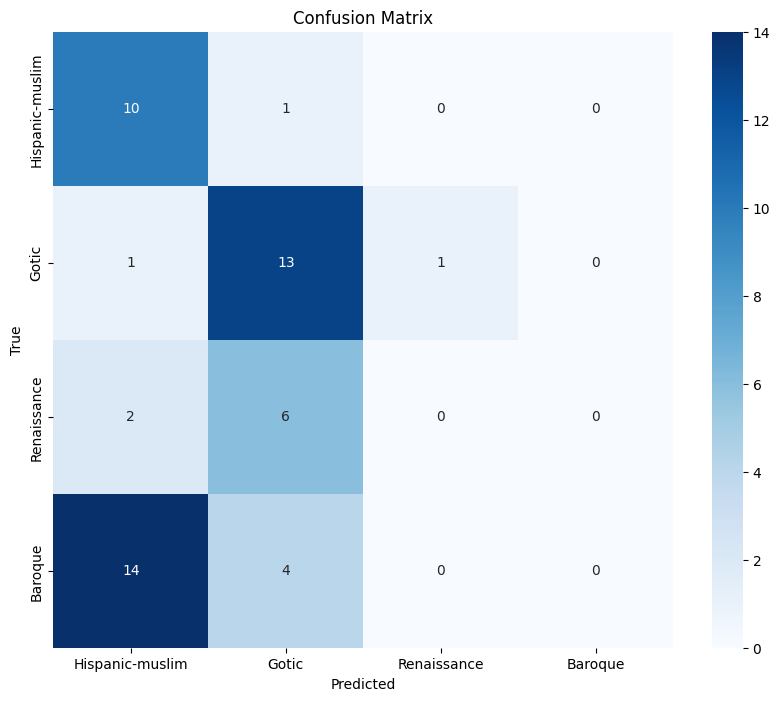

                 precision    recall  f1-score   support

Hispanic-muslim       0.37      0.91      0.53        11
          Gotic       0.54      0.87      0.67        15
    Renaissance       0.00      0.00      0.00         8
        Baroque       0.00      0.00      0.00        18

       accuracy                           0.44        52
      macro avg       0.23      0.44      0.30        52
   weighted avg       0.23      0.44      0.30        52



/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/orfeo/cephfs/home/dssc/adellasiega/jupyter/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

true_labels = []
predicted_labels = []

csv_path = "./Data/Dataset-IGRB1092_14cls/test.csv"
test_data = pd.read_csv(csv_path)

for index, row in test_data.iterrows():
    image_path = row["path"]
    image_path = image_path[1:]
    true_labels.append(row["class"])
    
    # Predici lo stile dell'immagine
    _, _, _, global_predicted_class = predict_and_explain(
        detector, classificator, image_path, threshold=0.5, 
        styles_map=styles_map, archi_features=archi_features, device=device
    )

    if global_predicted_class == "Hispanic-muslim" :
        predicted_labels.append(0)
    
    if global_predicted_class == "Gotic" :
        predicted_labels.append(1)
    
    if global_predicted_class == "Renaissance" :
        predicted_labels.append(2)
    
    if global_predicted_class == "Baroque" :
        predicted_labels.append(3)

    else: print(global_predicted_class)

    
    if index > 50:
        break

# Calcola confusion matrix
print(true_labels)
print(predicted_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizza confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=styles_map.values(), yticklabels=styles_map.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Report di classificazione
print(classification_report(true_labels, predicted_labels, target_names=styles_map.values()))
